# Recap

+ So far we have a **distributional semantics** based approach for representing words. 
- However this one has some problems. Dimensions. Others as well.

# Word Embeddings

A dense space vector. Used to predict contexts of words. A lot of **interesting** properties emerge.

<div>
<img src="../resources/imgs/w2v1.png" width="70%" align="left"/>
</div>

# Word2Vec

A famous algorithm for creating Word Embeddings

In [39]:
from collections import Counter 
from tqdm.auto import tqdm
from datasets import load_dataset
from matplotlib import pyplot as plt
import numpy as np
import json
from pprint import pprint
from numpy import dot
from numpy.linalg import norm
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec
from pathlib import Path

! free -h

              total        used        free      shared  buff/cache   available
Mem:            15G        6,7G        1,9G        549M        6,7G        7,7G
Swap:          979M        331M        648M


## Loading Vectors from Disk
And put them in a user friendly class

In [2]:
with Path('../resources/vectors/googlenews/vocab.json').open('r') as f:
    vocab = json.load(f)
    
with Path('../resources/vectors/googlenews/vectors.npy').open('rb') as f:
    vectors = np.load(f)

In [17]:
def cosine(v1, v2):
  """
  cosine similarity of two vectors
  NB: Standard metric to measure similarity between word vectors
  
  Hint: look at the imports in cell above ;)
  """
  return dot(v1, v2)/(norm(v1)*norm(v2))

class WordVectors:
    
    def __init__(self, vocab, vectors):
        self.vocab = vocab
        self.vectors = vectors
        self.zerovec = np.zeros((300), dtype=np.float)
        
        self._norm = norm(vectors, axis=1)
        self.id_to_tok = {i:tok for tok, i in vocab.items()}
        
    def safely_vectorize(self, toks):
        return [self.vectors[self.vocab[tok]] for tok in toks if tok in self.vocab]
        
    def __call__(self, k):
        # If token exists 
        if k in vocab:
            return self.vectors[self.vocab[k]]
        elif k.lower() in vocab:
            return self.vectors[self.vocab[k.lower()]]
        elif k[0].upper()+k[1:].lower() in vocab:
            return self.vectors[self.vocab[k[0].upper()+k[1:].lower()]]
        else:
            return self.zerovec
        
    def __len__(self):
        return len(self.vocab)
    
    def most_similar(self, word, k: 10, normalize=True):
        if isinstance(word, str):
            wid = self.vocab.get(word, -1)
            if wid < 0:
                return None
            v = self.vectors[wid]
        elif isinstance(word, np.ndarray) and len(word.shape) == 1:
            v = word
        else:
            raise TypeError(f"Unknown Type of word: {type(word)} ")
            
        cosines = np.dot(self.vectors, v) 
        if normalize:
            cosines = cosines / self._norm / norm(v)
        cosines_ind = np.argsort(-cosines)[:k]
        return [(self.id_to_tok[tokid], cosines[tokid]) for tokid in cosines_ind]
    
    def analogy2(self, wa, wb, wc, k=10):
        if wa in self.vocab and wb in self.vocab and wc in self.vocab:

            diff = self(wa) - self(wb) + self(wc)
            dists = sorted([(tok, float(norm(diff - self.vectors[i]))) for tok, i in self.vocab.items() if not tok in [wa, wb, wc]], key=lambda x: x[1])
            
            return dists[:k]
        else:
            return None
        
    def analogy(self, wa, wb, wc, k=10):
        if wa in self.vocab and wb in self.vocab and wc in self.vocab:

            diff = self(wb) + self(wc) - self(wa)
            dists = sorted([(tok, float(norm(diff - self.vectors[i]))) for tok, i in self.vocab.items() if not tok in [wa, wb, wc]], key=lambda x: x[1])
            
            return dists[:k]
        else:
            return None
        
# Lets trim this to nwords
n_words = 500000
short_vocab = {}
for tok,i in vocab.items():
    if i < n_words:
        short_vocab[tok] = len(short_vocab)
vocab = short_vocab
vectors = vectors[:n_words]
w2v = WordVectors(vocab, vectors)

w2v = WordVectors(vocab, vectors)
len(vectors), len(vocab), w2v.__len__()
! free -h

              total        used        free      shared  buff/cache   available
Mem:            15G        6,7G        2,0G        560M        6,7G        7,8G
Swap:          979M        331M        648M


In [4]:
# Visualization
from sklearn.decomposition import PCA
#%matplotlib notebook
import matplotlib.pyplot as plt
#plt.style.use('ggplot')

def plot_word2vec_embedding(model, projection="pca", 
                            words=None, 
                            plot_dir=None,
                            sample=0):
        
    vecs = np.array([model(w) for w in words])
    print(vecs.shape)

    if projection == "pca":
      pca_representations = PCA().fit_transform(vecs)[:,:2]
    else:
      raise(Exception(f"{projection} not supported"))
    
    fig = plt.figure(figsize=(9,9))
    plt.scatter(pca_representations[:,0], pca_representations[:,1], edgecolors='k', c='r')
    fig.set_dpi(600.0)
    for word, (x,y) in zip(words, pca_representations):
        plt.text(x+0.05, y+0.05, word)
    if plot_dir:
      plt.savefig(plot_dir)

# Property A: Similar Words -> Similar Vectors

In [5]:
print(f"W2V Cosine of 'dog', and 'cat' is {cosine(w2v('dog'), w2v('cat')):.4f}")
print(f"W2V Cosine of 'dog', and 'fork' is {cosine(w2v('dog'), w2v('fork')):.4f}")
print('----')
print(f"W2V Cosine of 'pen', and 'man' is {cosine(w2v('pen'), w2v('man')):.4f}")
print(f"W2V Cosine of 'pen', and 'pencil' is {cosine(w2v('pen'), w2v('pencil')):.4f}")

W2V Cosine of 'dog', and 'cat' is 0.7609
W2V Cosine of 'dog', and 'fork' is 0.1228
----
W2V Cosine of 'pen', and 'man' is 0.1282
W2V Cosine of 'pen', and 'pencil' is 0.5768


In [6]:
# Similarity 
# 1- computing the cosine between the vector of 'dog' and all the other words
# 2- get the top-10 most similar words 
# most_similar does those two steps 
w2v.most_similar('dog', 20)

[('dog', 0.99999994),
 ('dogs', 0.8680491),
 ('puppy', 0.81064284),
 ('pit_bull', 0.78039604),
 ('pooch', 0.76273775),
 ('cat', 0.76094574),
 ('golden_retriever', 0.7500902),
 ('German_shepherd', 0.7465175),
 ('Rottweiler', 0.7437615),
 ('beagle', 0.74186224),
 ('pup', 0.7406911),
 ('Pomeranian', 0.7238622),
 ('canines', 0.72212464),
 ('chihuahua', 0.7173918),
 ('pet', 0.7164785),
 ('schnauzer', 0.7128096),
 ('Shih_Tzu', 0.7095322),
 ('pit_bull_mix', 0.70757806),
 ('dachshund', 0.70723194),
 ('Labrador_retriever', 0.7069686)]

#### Q: Do we want to implement the `most_similar` method ourself?

In [7]:
def most_similar(w2v, word, k):
    ...

In [8]:
w2v.vocab.__len__()

500000

# Property B: Vector Space

(30, 300)


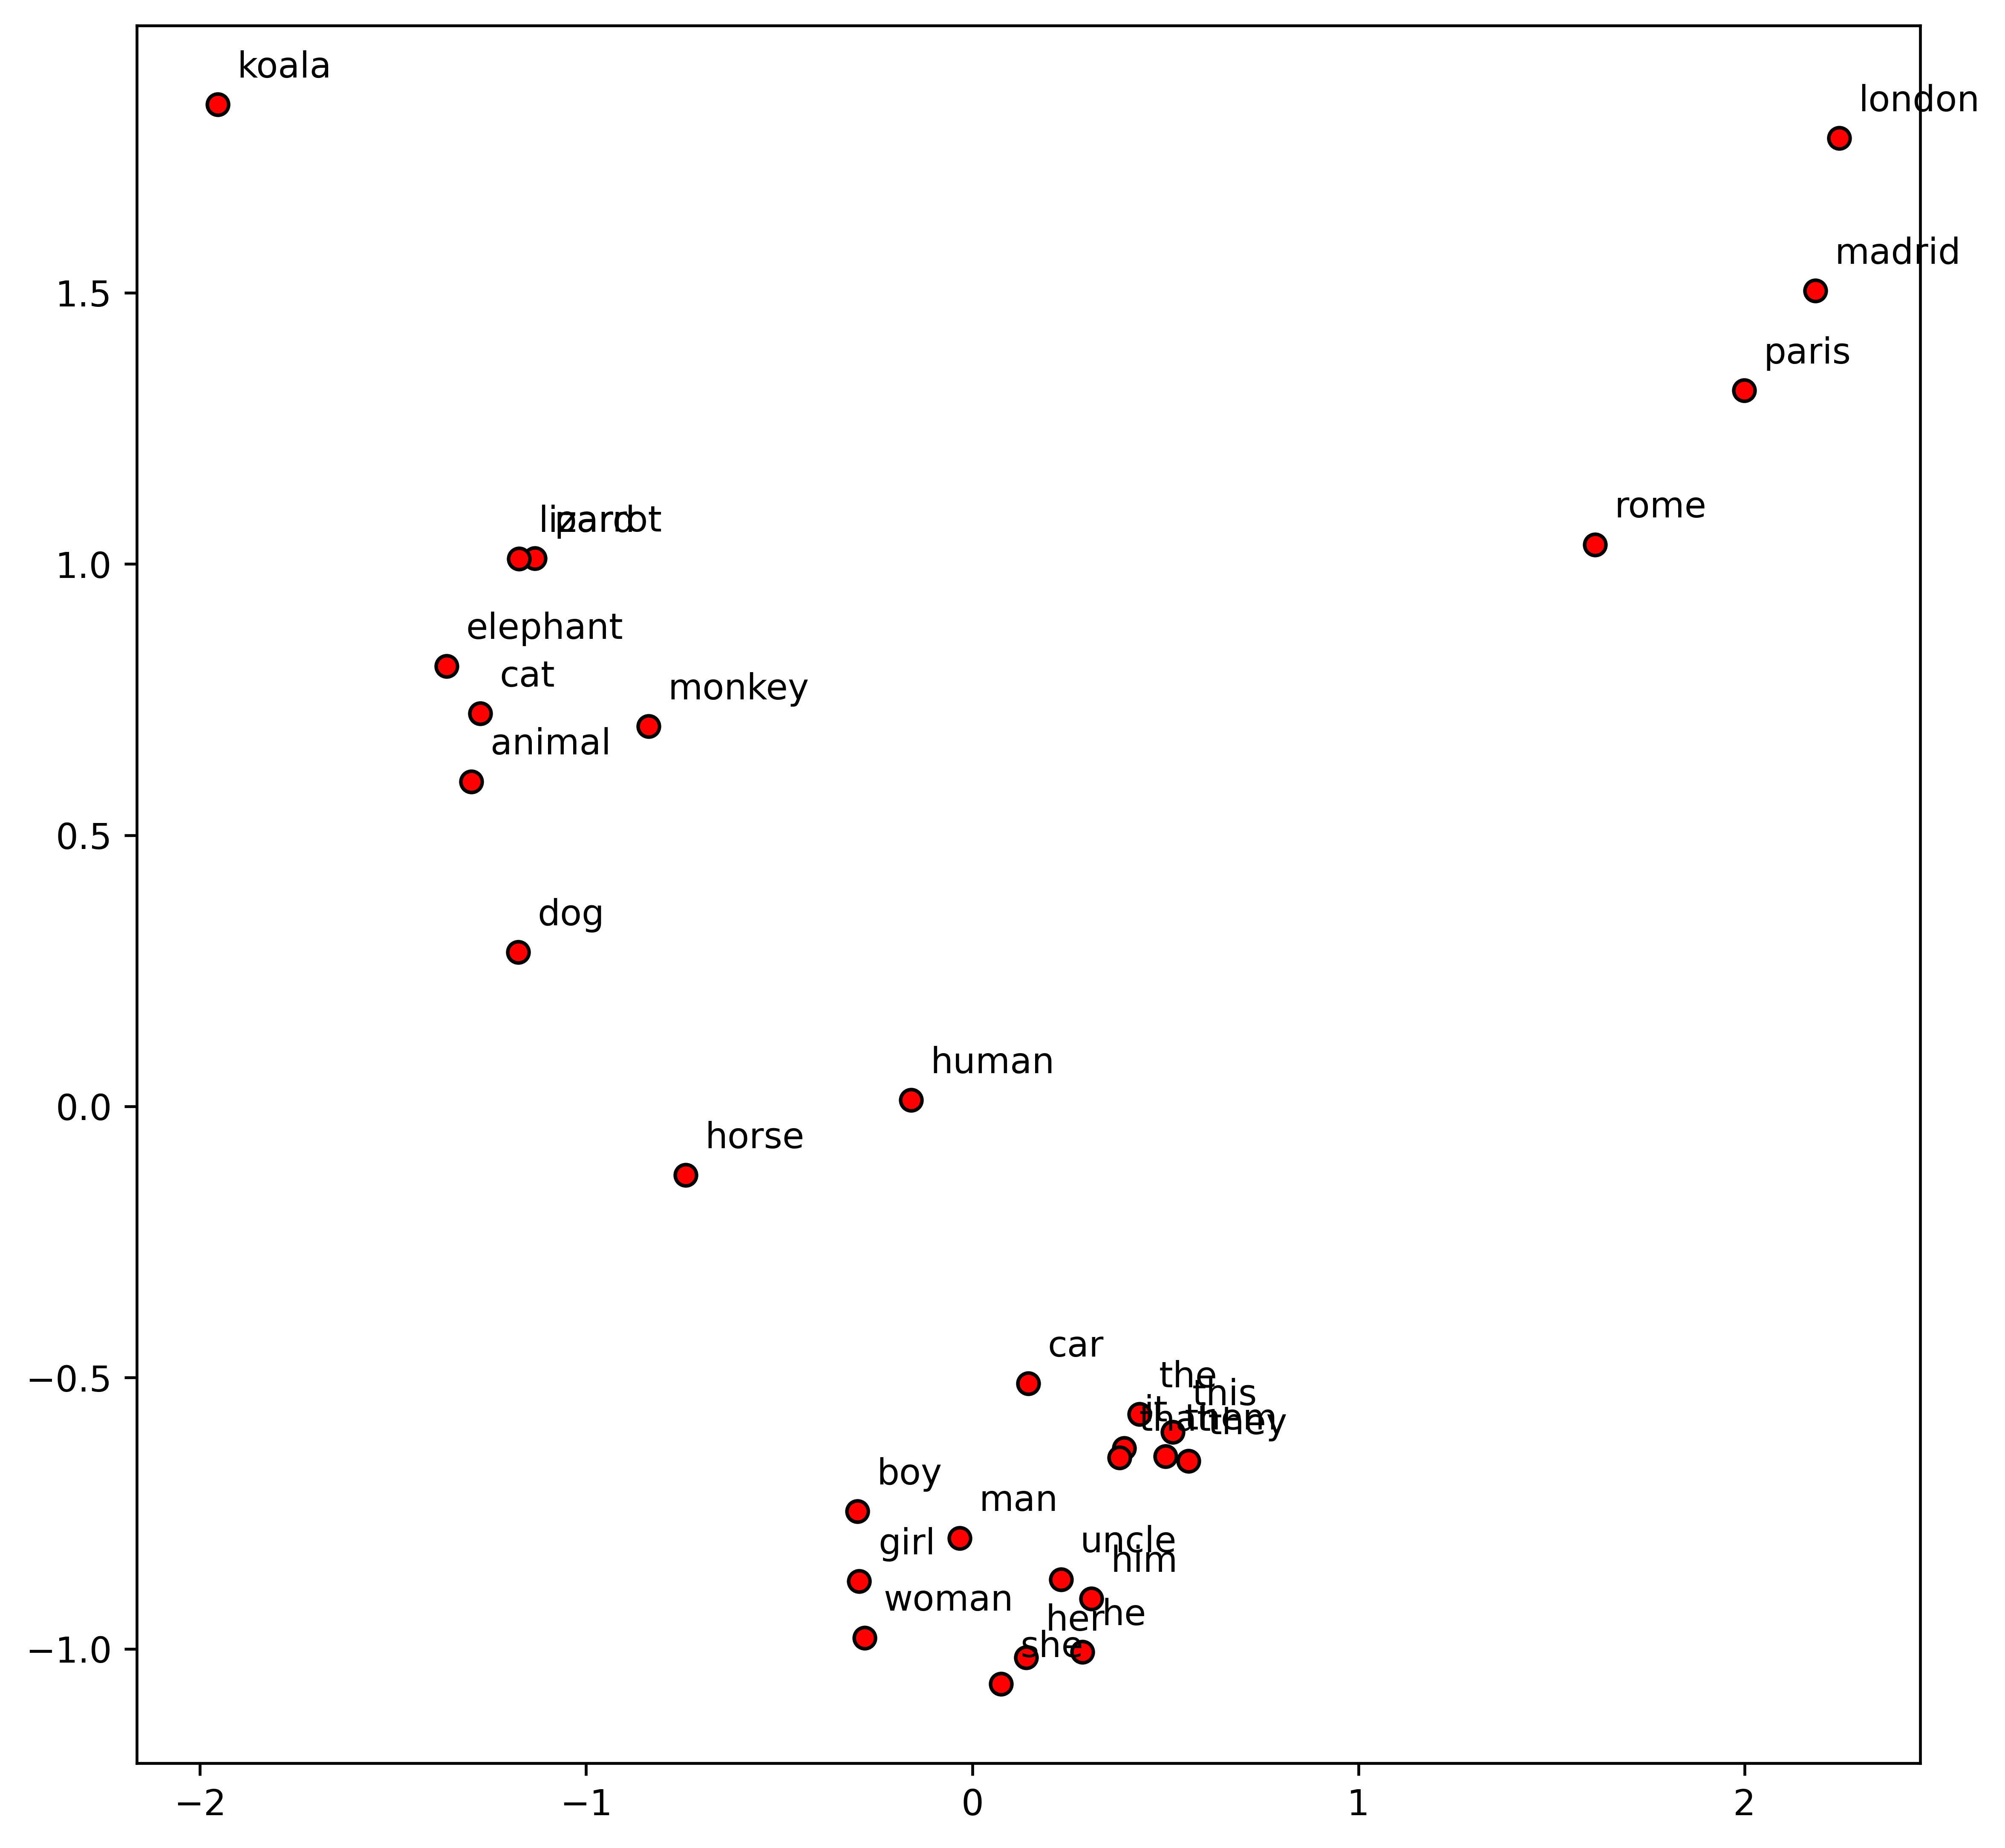

In [9]:
plot_word2vec_embedding(w2v, 
                        words = ['dog', 'cat', 'animal', 'elephant', 'car', 'human','horse', 'monkey', 'parrot', 'koala', 'lizard',
                         #  'eating', 'barking',
                         'man', 'woman',"girl","boy","uncle", 
                         "he", "she", "her", "him", "they", "them", "it",
                         "the", "that","this", 
                         'paris', 'madrid', 'london', "rome"],
#                          plot_dir="./plot_2.png",
                         )

(20, 300)


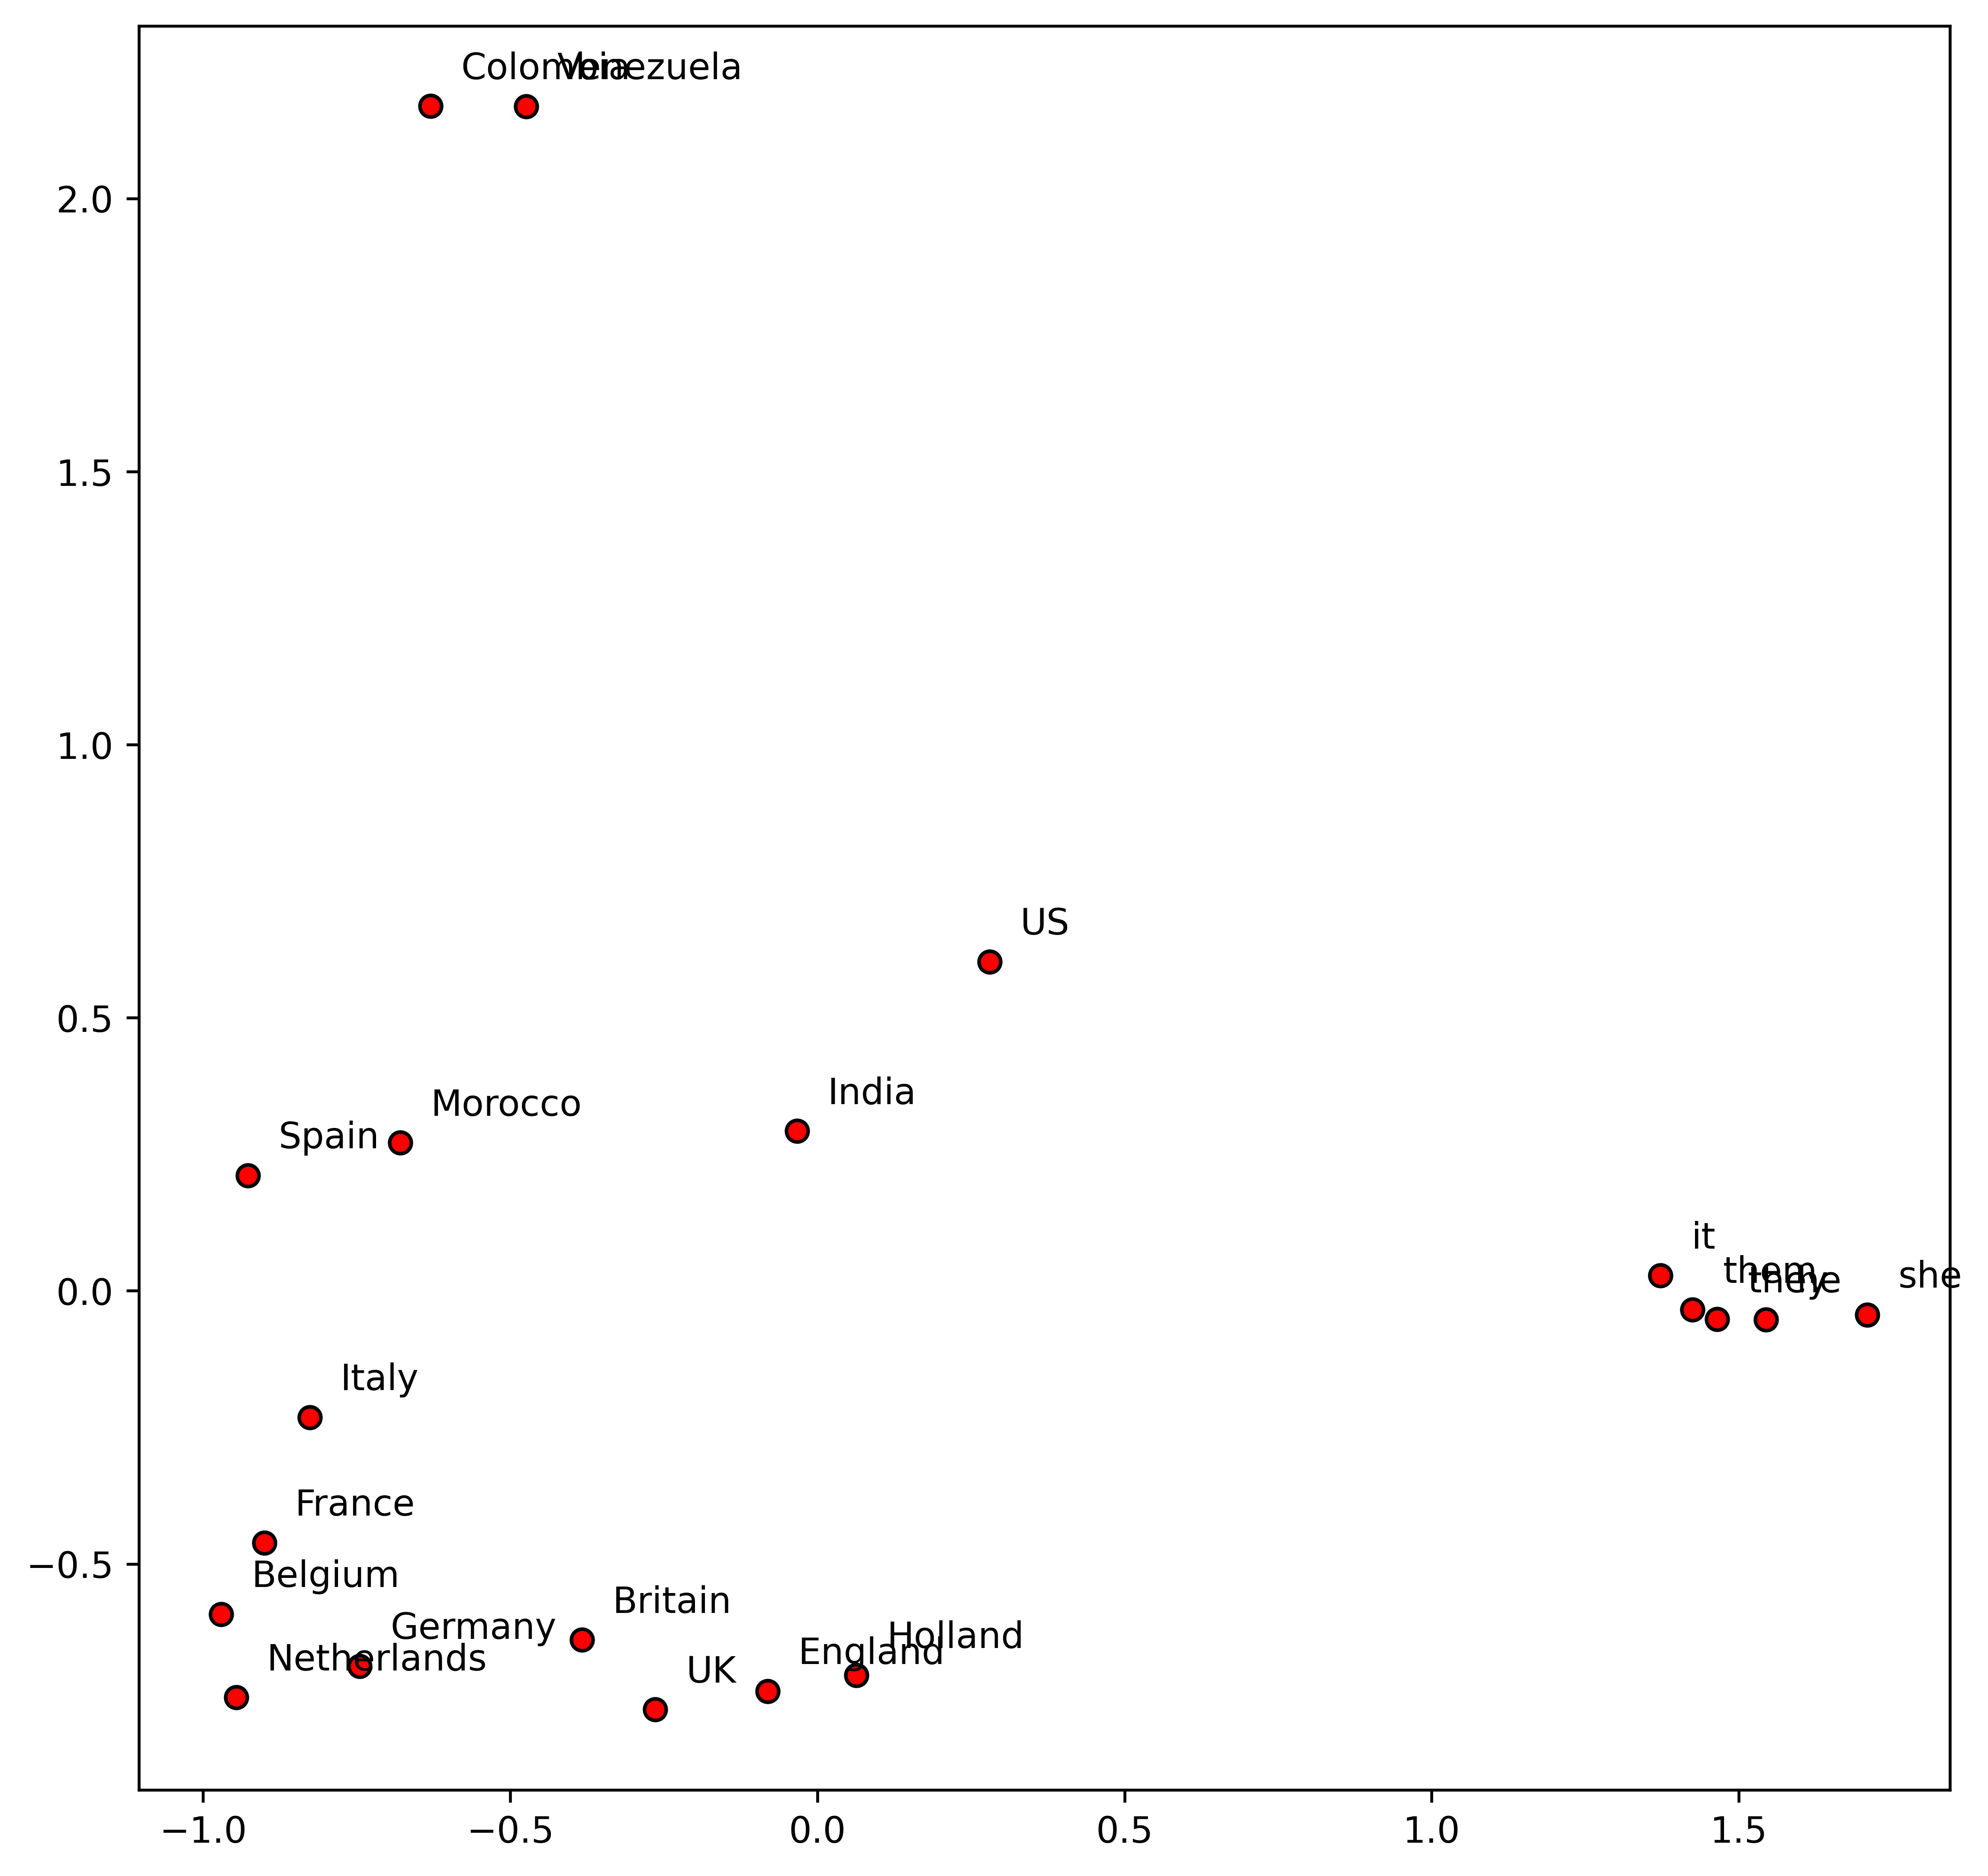

In [10]:
plot_word2vec_embedding(
    w2v, words = ['France', 'Germany', 'Netherlands', 'Holland', 'Belgium', 'Spain', 'Italy', 'Venezuela', 'England', 
                  'Britain', 'UK', 'US', 'India', 'Morocco', 'Colombia', 'he', 'she', 'they', 'them', 'it']
)

# Countries appear closer than pronouns
# European countries are closer. Latin America countries are further away

> Similar words are closer in vector space -> Knowledge learned for a word is also applicable for similar words.

E.g. what the parameters learn about 'Thursday', may also be applicable for 'Wednesday':

In [11]:
cosine(w2v('Thursday'), w2v('Wednesday'))

0.98166853

(18, 300)


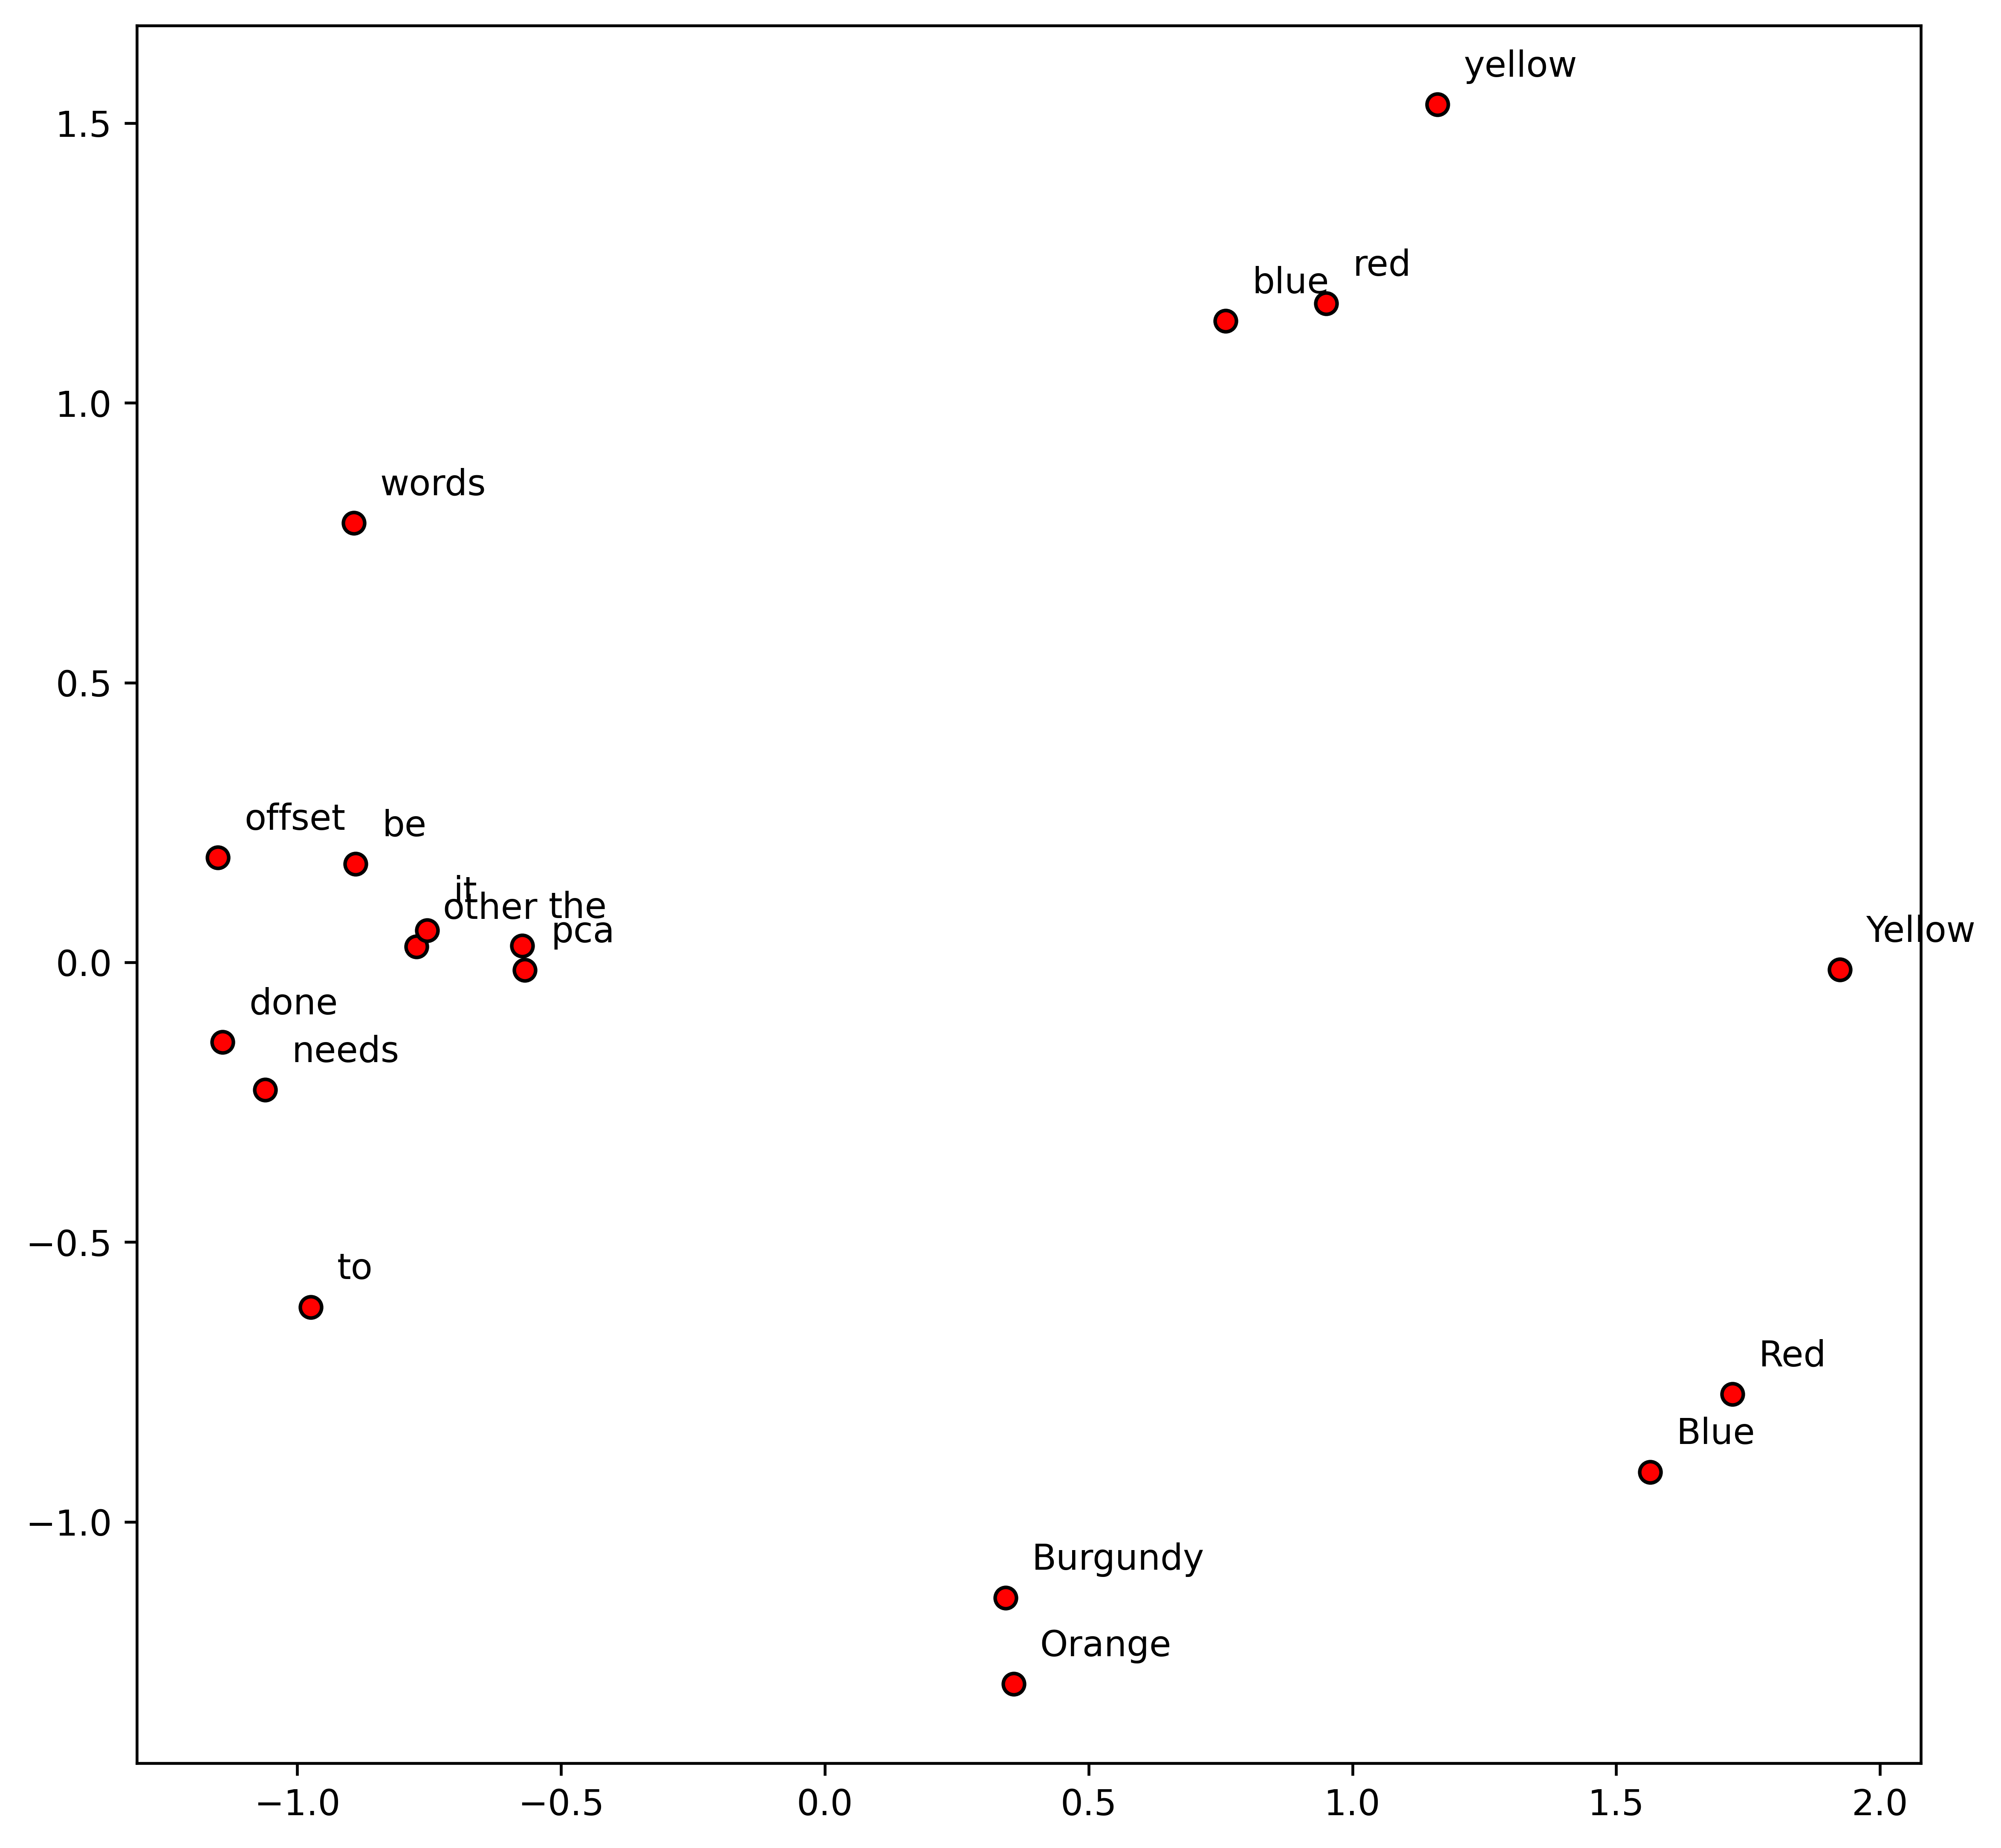

In [12]:
plot_word2vec_embedding(
    w2v, words = ['blue', 'Blue', 'red', 'Red', 'Burgundy', 'Orange', 'Yellow', 'yellow', 
                   'other', 'words', 'to', 'offset', 'the', 'pca', 'it', 'needs', 'be', 'done'
                 ]
)

# the blue red yellow; Blue Red Yellow pairs make an interesting pattern.

# Property C: Analogies

**King is to Queen, as Man isto ??**: 

<div>
<img src="../resources/imgs/analogies.png" width="500"/>
</div>

$$
\vec{\mathbf{w}}_{king} - \vec{\mathbf{w}}_{queen} \simeq \vec{\mathbf{w}}_{man} - \vec{\mathbf{w}}_{woman}
$$


> **Translation Distance in the Vector Space have semantic meanings.**


<div>
<img src="../resources/imgs/analogies-a.png" width="80%"/>
</div>

$$
\vec{\mathbf{d}}_{gender} = \vec{\mathbf{w}}_{king} - \vec{\mathbf{w}}_{queen}\\
\vec{\mathbf{w}}_{man} = \vec{\mathbf{w}}_{woman} + \vec{\mathbf{d}}_{gender}
$$

In [95]:
# Let's do this manually?
wa, wb, wc = 'man', 'king', 'woman'

#### Analogies can capture Gender-ness

In [23]:
# man isto king as woman isto woman
# man:king::woman:x
# w_man - w_king = w_woman - w_??
# w_?? = w_woman - w_man + w_king
w2v.analogy('man', 'king', 'woman')

[('queen', 2.2986576557159424),
 ('monarch', 2.8295388221740723),
 ('princess', 2.8501088619232178),
 ('prince', 2.910748243331909),
 ('kings', 2.925889730453491),
 ('queens', 3.1065421104431152),
 ('King', 3.1076297760009766),
 ('Pic_ITV', 3.117513656616211),
 ('CNA_ls', 3.134202241897583),
 ('With_INQ7.net', 3.1397430896759033)]

#### Analogies can capture Capitalisation

In [25]:
# Back to the image above
# Red:Blue::red:?
w2v.analogy('Red', 'Blue', 'red', k=2)

[('blue', 2.4491684436798096), ('yellow', 2.7279107570648193)]

In [30]:
# Pen:Create::pen:??
w2v.analogy('Pen', 'Create', 'pen', k=2)

[('Creating', 3.7391178607940674), ('create', 3.7944552898406982)]

#### Analogies can capture lexical things like Tenses

In [27]:
# ran:run::ate:??
w2v.analogy('ran', 'run', 'ate', k=2)

[('eat', 2.6096479892730713), ('eaten', 2.812523365020752)]

#### Like Pluralization

In [31]:
# bing:brings::sing:??
w2v.analogy('bring', 'brings', 'sing', k=2)

[('sings', 2.385129928588867), ('singing', 2.641793727874756)]

In [32]:
# tallest:tall :: longest:
w2v.analogy('tallest', 'tall', 'longest', k=5)

[('long', 3.433107852935791),
 ('short', 3.6818881034851074),
 ('_Sen', 3.837351083755493),
 ('%_#F########_3v.jsn', 3.8411316871643066),
 ('By_MaltaMedia_News', 3.846298933029175)]

#### They can be about stereotypes

In [33]:
# wine isto france as ?? isto germany
# france:wine :: germany:??
w2v.analogy('france', 'wine', 'germany', k=3)

[('beer', 3.785550355911255),
 ('wines', 3.8049728870391846),
 ('winery', 3.9742610454559326)]

#### They can be about world knowledge

In [46]:
# paris:france::tokyo:??
w2v.analogy('Paris','France', 'Tokyo', k=2)

[('Japan', 1.9730453491210938), ('Japanese', 2.645346164703369)]

In [49]:
# Hollande: France :: Obama: ?? (The model was trained in 2014)
w2v.analogy('Hollande', 'France', 'Obama')

[('United_States', 4.477004528045654),
 ('U.S.', 4.563506603240967),
 ('United_Sates', 4.675754070281982),
 ('Unites_States', 4.700917720794678),
 ('President_Barack_Obama', 4.748849391937256),
 ('_Jan', 4.788264751434326),
 ('White_House', 4.793633937835693),
 ('Great_Britain', 4.7946600914001465),
 ('Ap_Us', 4.794960975646973),
 ('_Sept', 4.7992634773254395)]

 # Bias: It can be problematic
 
 ### Sexist

In [41]:
# he: computer_programmer :: she: ??
w2v.analogy('he', 'computer_programmer', 'she', k=2)  # homeowner

[('homemaker', 3.569093942642212), ('graphic_designer', 3.5722179412841797)]

In [44]:
# father: doctor :: mother: ??
w2v.analogy('father', 'doctor', 'mother', k=2)  # nurse

[('nurse', 2.4803545475006104), ('doctors', 2.5925068855285645)]

In [94]:
# he: tall :: she: ??
w2v.analogy('he', 'tall', 'she', k=2) # petite, skinny

[('petite', 2.6665244102478027), ('skinny', 3.067469358444214)]

### and Racist

In [71]:
print(f"Adam: educated :: John: {w2v.analogy('Adam', 'educated', 'John')[0][0]}")
print(f"Adam: educated :: Lamar: {w2v.analogy('Adam', 'educated', 'Lamar')[0][0]}")

Adam: educated :: John: Educated
Adam: educated :: Lamar: uneducated


In [73]:
print(f"Adam: polite :: John: {w2v.analogy('Adam', 'polite', 'John')[0][0]}")
print(f"Adam: polite :: Lamar: {w2v.analogy('Adam', 'polite', 'Lamar')[0][0]}")

Adam: polite :: John: courteous
Adam: polite :: Lamar: mannerly


In [91]:
print(f"Josh: good :: Hank: {w2v.analogy('Josh', 'good', 'Hank')[0][0]}")
print(f"Josh: good :: Jamel: {w2v.analogy('Josh', 'good', 'Jamel')[0][0]}")

Josh: good :: Hank: great
Josh: good :: Jamel: bad


PS: Source for these names come from Weat candidates: [github link](https://github.com/chadaeun/weat_replication/blob/master/weat/EuropeanAmerican_AfricanAmerican_Pleasant_Unpleasant)

# But How?

![TenorURL](https://media.tenor.com/mOR-MnUI3QEAAAAC/confused-white-persian-guardian.gif "how")

# Let's move to 6.3.2

## Algorithm

It needs:

1. A Corpus. 
2. Each word has a fixed-length vector (say 300 dimensions).
3. In your corpus, collect every word $w$, and the context around it $c$.
4. Use similarity of vectors for $w$ and $c$ to calculate the probability of the context given the word, i.e. $p(c|w)$.
5. Keep adjusting the vectors to maximize this probability.

In [ ]:
wikitext = load_dataset("wikitext", "wikitext-2-v1")
wikitext

In [ ]:
wikitext['train'][1]['text']

In [ ]:
vocab = {}
n_words_per_doc = []

for doc in tqdm(wikitext['train']):
    for token in doc['text'].replace('\n',' ').strip().split():
        vocab.setdefault(token, len(vocab))
    n_words_per_doc.append(len(vocab))
    
for doc in tqdm(wikitext['validation']):
    for token in doc['text'].replace('\n',' ').strip().split():
        vocab.setdefault(token, len(vocab))
    n_words_per_doc.append(len(vocab))
    

In [ ]:
# Make a vocab
word_counter = Counter()
for line in wikitext['train']:
    word_counter.update()